# Data

## Import libraries and Set Options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ParameterGrid
from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   PolynomialFeatures)
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error

from daftpy.daftmodel import split_data, scores_statistics, metrics_regression, plot_learning_curves

import joblib

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

## Load Data

In [3]:
sale_data = pd.read_csv('data_available/sale_data_post_out.csv', sep=',')
sale_data.shape  #### cambiar esto

(7387, 34)

In [4]:
features = [
    
    'price',
    'floor_area',
    'views',
    'latitude',
    'longitude',
#    'bedroom',
    'bathroom',
#    'sale_type',
    'type_house',
#    'postcode',
#    'state_district',
#    'county',
#    'city_district',
#    'road',
#    'place',
    'code',
#    'admin1',
#    'cities'
]

data = sale_data[features].copy()
data.shape

(7387, 8)

In [5]:
num_features = list(data.select_dtypes('number').columns) #X_train
num_features.remove('price')
cat_features =  list(data.select_dtypes('object').columns)

num_feat_df = pd.DataFrame({'numerical': num_features}) 
cat_feat_df = pd.DataFrame({'categorical': cat_features})

feat_df = num_feat_df.merge(cat_feat_df, how='left', left_index=True, right_index=True).fillna(' ')
feat_df

,numerical,categorical
0,floor_area,type_house
1,views,code
2,latitude,
3,longitude,
4,bathroom,


In [6]:
levels_type_house = data.type_house.unique()
levels_code = data.code.unique()

cat_feat_df['n_levels'] = [data.type_house.nunique(), data.code.nunique()]
cat_feat_df['sample'] = [levels_type_house, levels_code[:5]]
cat_feat_df # mejorar

,categorical,n_levels,sample
0,type_house,2,"[house, apartment]"
1,code,137,"[D09, T23, F91, V95, R32]"


## Split Data

In [7]:
X_train, X_test, y_train, y_test = split_data(data=data, 
                                              target='price', 
                                              test_size=.2, 
                                              output='X_y_train_test',
                                              random_state=42)

X_train: (5909, 7) 
X_test: (1478, 7) 
y_train: (5909,) 
y_test: (1478,) 



------------

# Metrics

In [8]:
scoring = {'r2': 'r2', 
           'MAE': 'neg_mean_absolute_error', 
           'MAPE': 'neg_mean_absolute_percentage_error', 
           'RMSE': 'neg_root_mean_squared_error'}

# Models

## Multiple Linear Regression

En estadística, el **coeficiente de determinación**, denominado R² y pronunciado R cuadrado, es un estadístico usado en el contexto de un modelo estadístico cuyo principal propósito es predecir futuros resultados o probar una hipótesis. El coeficiente determina la calidad del modelo para replicar los resultados, y la proporción de variación de los resultados que puede explicarse por el modelo.

Es el porcentaje de la variación en la variable de respuesta que es explicado por un modelo lineal. Es decir:

R-cuadrado = Variación explicada / variación total

El R-cuadrado siempre está entre 0 y 100%:

https://scikit-learn.org/stable/modules/cross_validation.html

In [9]:
num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
#    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  # No hace nada si ya transformadas
                                      #handle_unknown='ignore'
    ])
# Las transforme antes para evitar problemas no las variables a la hora de predecir e el test_set...

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


lr_pipe_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', # esto lo puedo agnadir en los otros pipes
                              fill_value=None)),
    ('regressor', LinearRegression())
    ])

In [10]:
scores_lr, scores_resume_lr = scores_statistics(estimator=lr_pipe_estimator, 
                                                scoring_dict=scoring, 
                                                X_train=X_train, 
                                                y_train=y_train, 
                                                cv=10, 
                                                return_train_score=False)

r2 mean: 0.6581505970522035
r2 std: 0.03247492814306588 

MAE mean: -108719.58221709491
MAE std: 5568.4947907050655 

MAPE mean: -0.32069981130761466
MAPE std: 0.015889144852600887 

RMSE mean: -176983.98634043717
RMSE std: 12945.409397794008 



### Overfitting-Underfitting Analysis

#### Evaluating on the Training and Test Sets

We can identify if a machine learning model has overfit by first evaluating the model on the training dataset and then evaluating the same model on a holdout test dataset.

If the performance of the model on the training dataset is significantly better than the performance on the test dataset, then the model may have overfit the training dataset.

In [11]:
lr = lr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = lr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = lr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.6739892726197527
MAE: 106081.66588347829
MAPE: 0.31183387356867376
RMSE: 173716.41014659725

Performance on the test set:
 ----------
R²: 0.6468123069342815
MAE: 111099.76275851484
MAPE: 0.321239513969634
RMSE: 183180.30027983472



#### Learning Curves

In [15]:
plot_learning_curves(model=lr_pipe_estimator, 
                     X_train=X_train, 
                     y_train=y_train, 
                     X_test=X_test, 
                     y_test=y_test,
                     metric='mape')

/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


KeyboardInterrupt: 

The model is underfitting the training data, so we need to use more complex models or come up with better features.

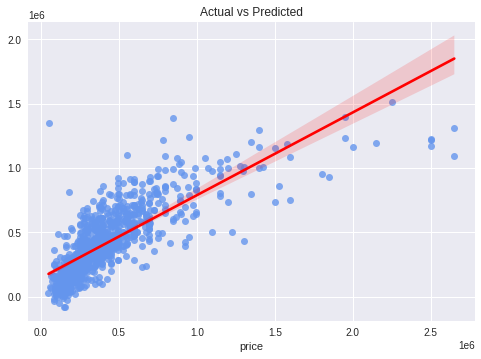

In [13]:
sns.regplot(x=y_test, y=lr_pipe_estimator.predict(X_test), 
            scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"})\
           .set_title('Actual vs Predicted');

-------------

------------

In [14]:
#joblib.dump(lr, 'models/linear_regression_01-11-2021.plk')

-------------------

## Polynomial Regression

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5909, 7), (1478, 7), (5909,), (1478,))

In [12]:
num_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('std_scaler', StandardScaler()),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


poly_pipe_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', LinearRegression())
                           ])

In [13]:
grid_search = GridSearchCV(estimator=poly_pipe_estimator, 
                           param_grid={'preprocessor__num__poly__degree': range(1, 10)}, 
                           cv=5, 
                           n_jobs=-1,
                        #   scoring='neg_mean_squared_error',
                        #   return_train_score=True
                          )

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
#grid_search.best_estimator_

{'preprocessor__num__poly__degree': 3}
0.7479684669015497


In [14]:
#pd.DataFrame(grid_search.cv_results_) # plotearlo

In [15]:
scores = scores_statistics(estimator=poly_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.7509266721418995
r2 std: 0.029110140197970813 

MAE mean: -94476.7902938415
MAE std: 3679.6981417813968 

MAPE mean: -0.2738010265729388
MAPE std: 0.010822070061438843 

RMSE mean: -150821.55756749702
RMSE std: 10517.670372640698 



In [24]:
poly = poly_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = poly.predict(X_train)
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)
#scores = scores_statistics(estimator=poly, 
 #                          scoring_dict=scoring, 
  #                         X_train=X_train, 
   #                        y_train=y_train, 
    #                       cv=10, 
     #                      return_train_score=False)

print('Performance on the test set:\n', '-'*10)
y_pred = poly.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)


Performance on the training set:
 ----------
R²: 0.7737738943989698
MAE: 90784.73634486872
MAPE: 0.2629339442693284
RMSE: 144709.23924104206

Performance on the test set:
 ----------
R²: 0.7341027244460809
MAE: 97188.98815136666
MAPE: 0.271332077376683
RMSE: 158939.89776053437



Train MAPE: 0.2611109420276826
Test MAPE: 0.2853709414090467


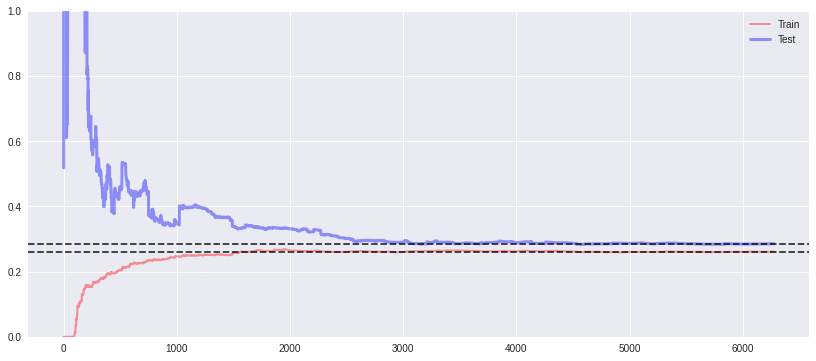

In [23]:
plot_learning_curves(model=poly_pipe_estimator, 
                     X_train=X_train, 
                     y_train=y_train, 
                     X_test=X_test, 
                     y_test=y_test)

In [ ]:
sns.regplot(x=y_test, y=poly_pipe_estimator.fit(X_train, y_train).predict(X_test), 
            scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"})\
           .set_title('Actual vs Predicted');

## Support Vector Machines

In [25]:
from sklearn.svm import LinearSVR

from sklearn.svm import SVR

In [60]:
num_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ('std_scaler', StandardScaler()),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


svmr_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', SVR()) 
                           ])
#  coef0=1,
# SVR(kernel='poly', degree=1, coef0=1, C=1) LinearSVR(epsilon=1)

In [62]:
grid_search = GridSearchCV(estimator=svmr_pipe_est, 
                           param_grid={
                               'regressor__degree': [1,3],
                               'regressor__epsilon': [.1], #[2,3,4,5,6,7]
                               'regressor__C': [50,60,70,80,90,100,120]
                           }, 
                           cv=6, 
                           n_jobs=-1,
                        #   scoring='neg_mean_squared_error',
                        #   return_train_score=True
                          )

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'regressor__C': 120, 'regressor__degree': 1, 'regressor__epsilon': 0.1}
-0.013184368454388343


In [195]:
svmr_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', SVR(C=))
])

scores = scores_statistics(estimator=svmr_pipe_est, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.045203904741535295
r2 std: 0.035952950581539446 

MAE mean: -170344.43310077215
MAE std: 9115.976506289258 

MAPE mean: -0.4697385455756007
MAPE std: 0.01665477946216525 

RMSE mean: -296411.5479336265
RMSE std: 22358.31989488538 



In [196]:
svmr = svmr_pipe_est.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = svmr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = svmr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
r2 mean: 0.045203904741535295
r2 std: 0.035952950581539446 

MAE mean: -170344.43310077215
MAE std: 9115.976506289258 

MAPE mean: -0.4697385455756007
MAPE std: 0.01665477946216525 

RMSE mean: -296411.5479336265
RMSE std: 22358.31989488538 

Performance on the test set:
 ----------
r2 mean: -0.032819611083068224
r2 std: 0.03568481931645495 

MAE mean: -182198.64373985882
MAE std: 16829.306285243172 

MAPE mean: -0.49935751926266647
MAPE std: 0.04205439690903595 

RMSE mean: -310508.0896312056
RMSE std: 40781.87479003184 



## K Nearest Neighbors Regressor

In [49]:
from sklearn.neighbors import KNeighborsRegressor

```python
KNeighborsRegressor(n_neighbors=5, 
                    *, 
                    weights='uniform', 
                    algorithm='auto', 
                    leaf_size=30, 
                    p=2, 
                    metric='minkowski', 
                    metric_params=None, 
                    n_jobs=None)
```

In [57]:
num_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ('std_scaler', StandardScaler()),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


knnr_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', KNeighborsRegressor())
                           ])

In [56]:
param_grid = [
#    {
 #       'regressor__n_neighbors': [5,10,15,20,25,30,35,40,45,50], 
  #  },
    {
        'preprocessor__num__poly__degree': [1,2,3,4,5],
        'regressor__n_neighbors': [5,10,15,20,25,30,35,40,45,50],
    }, 
]

grid_search = GridSearchCV(estimator=knnr_pipe_est, 
                           param_grid=param_grid,
                           cv=5, 
                           n_jobs=-1,
                        #   scoring='neg_mean_squared_error',
                        #   return_train_score=True
                          )

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'preprocessor__num__poly__degree': 1, 'regressor__n_neighbors': 10}
0.71811523350896


In [58]:
knnr_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', KNeighborsRegressor(n_neighbors=10,
                                      
                                     ))
                           ])

scores = scores_statistics(estimator=knnr_pipe_est, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.71811523350896
r2 std: 0.047035588574515515 

MAE mean: -94951.2568978797
MAE std: 3616.1771208504674 

MAPE mean: -0.2673478345689654
MAPE std: 0.006640880486903855 

RMSE mean: -160776.974205796
RMSE std: 12246.337737638607 



In [59]:
knnr = knnr_pipe_est.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = knnr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = knnr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.7808931429920254
MAE: 83952.01976645795
MAPE: 0.23402768381886224
RMSE: 142414.06577198117

Performance on the test set:
 ----------
R²: 0.7149744015727351
MAE: 94532.48254397836
MAPE: 0.25724751266987317
RMSE: 164557.59012118593



## Decission Tree Regressor

In [27]:
num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


dtr_pipe_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', DecisionTreeRegressor()) # max_depth=9spoiler
                           ])

In [174]:
grid_search = GridSearchCV(estimator=dtr_pipe_estimator, 
                           param_grid={
                               'preprocessor__num__poly__degree': [1], #[1,2,3,4],
                               'regressor__max_depth': [7], #range(5, 15), #[2,3,4,5,6,7]
                               'regressor__min_samples_leaf': [16], #range(8, 20),
                               'regressor__min_samples_split': [43], #[2, 43],
                               'regressor__max_leaf_nodes': range(59, 100),
                         #      'regressor__max_features':,
                           }, 
                           cv=5, 
                           n_jobs=-1,
                        #   scoring='neg_mean_squared_error',
                        #   return_train_score=True
                          )

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)


{'preprocessor__num__poly__degree': 1, 'regressor__max_depth': 7, 'regressor__max_leaf_nodes': 68, 'regressor__min_samples_leaf': 16, 'regressor__min_samples_split': 43}
0.7301463525943861


In [28]:
#pd.DataFrame(grid_search.cv_results_)

In [28]:
dtr_pipe_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', DecisionTreeRegressor(max_depth=10,
                                        min_samples_leaf=16,
                                        min_samples_split=43,
                                        max_leaf_nodes=68
                                       )) 
                           ])

scores = scores_statistics(estimator=dtr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7347439806116778
r2 std: 0.024814399630088618 

MAE mean: -95341.41736197876
MAE std: 1686.2968105662758 

MAPE mean: -0.27692435189721787
MAPE std: 0.006257078986299098 

RMSE mean: -156514.0008343089
RMSE std: 7832.77912950293 



In [29]:
dtr = dtr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = dtr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = dtr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.7927341211787164
MAE: 86542.06835968455
MAPE: 0.25752620175637614
RMSE: 138512.4486203107

Performance on the test set:
 ----------
R²: 0.7304601782182829
MAE: 96912.11046384604
MAPE: 0.27164761682651445
RMSE: 160024.8593006069



Train MAPE: 0.2506263998258523
Test MAPE: 0.2912945855355977


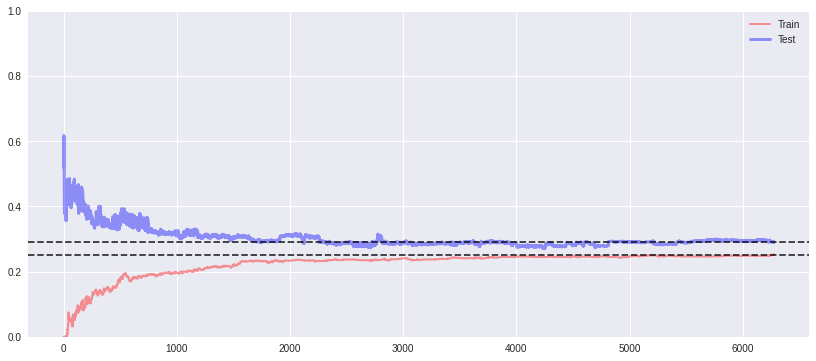

In [50]:
plot_learning_curves(model=dtr_pipe_estimator, 
                     X_train=X_train, 
                     y_train=y_train, 
                     X_test=X_test, 
                     y_test=y_test)

In [29]:
X_test.shape, y_test.shape

((1109, 7), (1109,))

In [ ]:
sns.regplot(x=y_test, y=dtr_pipe_estimator.fit(X_train, y_train).predict(X_test), 
            scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"})\
           .set_title('Actual vs Predicted');

## Random Forest Regressor

In [30]:
num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


rfr_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', RandomForestRegressor())
                           ])

```python
RandomForestRegressor(n_estimators=100, 
                      *, 
                      criterion='squared_error', 
                      max_depth=None, 
                      min_samples_split=2, 
                      min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, 
                      max_features='auto', 
                      max_leaf_nodes=None, 
                      min_impurity_decrease=0.0, 
                      bootstrap=True, 
                      oob_score=False, 
                      n_jobs=None, 
                      random_state=None, 
                      verbose=0, 
                      warm_start=False, 
                      ccp_alpha=0.0, 
                      max_samples=None)
```

In [ ]:
#pd.DataFrame(grid_search.cv_results_).tail()

In [47]:
rfr_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', RandomForestRegressor(
        n_estimators=93,
#        max_depth=10,
#        min_samples_split=43,
#        min_samples_leaf=16,
#        max_leaf_nodes=68,
        n_jobs=-1,
                                       )) 
                           ])
#estimator

scores = scores_statistics(estimator=rfr_pipe_est, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.8077591736690793
r2 std: 0.035555715263534515 

MAE mean: -76754.65314047014
MAE std: 3213.3905848520285 

MAPE mean: -0.21649859614401995
MAPE std: 0.01028444947741166 

RMSE mean: -131757.62978555978
RMSE std: 9791.996921657315 



In [48]:
rfr = rfr_pipe_est.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = rfr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = rfr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.974548694222565
MAE: 28042.828211749158
MAPE: 0.07900250604914448
RMSE: 48537.78292453019

Performance on the test set:
 ----------
R²: 0.810149847625738
MAE: 77240.18932151847
MAPE: 0.20916867164901815
RMSE: 134301.68471433062



The model is overfitting the training data. Necesitamos regularizar!!

In [ ]:
plot_learning_curves(model=rfr_pipe_est, 
                     X_train=X_train, 
                     y_train=y_train, 
                     X_test=X_test, 
                     y_test=y_test)

In [ ]:
sns.regplot(x=y_test, y=rfr_pipe_est.fit(X_train, y_train).predict(X_test), 
            scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"})\
           .set_title('Actual vs Predicted');